# 使用Densenet提取特征(雾)

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import h5py
import cv2 as cv


import tensorflow as tf
from tensorflow.keras.layers import Input, ZeroPadding2D, Activation, Dense, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, Concatenate, SpatialDropout2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal, random_normal
from tensorflow.keras.losses import MSE, MAE
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras import backend as K


2024-03-08 14:34:54.179099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Useful functions

import os
os.chdir('../')
from Densenet.Utils_colab import *

## 训练集 验证集 测试集

In [3]:
# Path to the database

hdf5_path = './test_data/V12_YOLO_par_3_9600.hdf5'
X_train, X_dev, X_test, Y_train, Y_dev, Y_test = load_dataset_train_dev_test(hdf5_path)
print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_dev.shape), "X_test shape : " + str(X_test.shape))
print("Y_train shape : " + str(Y_train.shape), "Y_dev shape : " + str(Y_dev.shape), "Y_test shape : " + str(Y_test.shape))

X_train shape : (6720, 64, 64, 1) X_dev shape : (1920, 64, 64, 1) X_test shape : (960, 64, 64, 1)
Y_train shape : (6720, 4) Y_dev shape : (1920, 4) Y_test shape : (960, 4)


In [5]:
################ Confirming data retrieved shapes 确定数据形状 ###############

##### to rgb

X_train = gray_to_rgb(X_train)
X_dev = gray_to_rgb(X_dev)
X_test = gray_to_rgb(X_test)

print("X_train shape : " + str(X_train.shape), "X_dev shape : " + str(X_dev.shape), "X_test shape : " + str(X_test.shape)) 
print("Y_train shape : " + str(Y_train.shape), "Y_dev par shape : " + str(Y_dev.shape), "Y_test par shape : " + str(Y_test.shape)) 


X_train shape : (6720, 64, 64, 3) X_dev shape : (1920, 64, 64, 3) X_test shape : (960, 64, 64, 3)
Y_train shape : (6720, 4) Y_dev par shape : (1920, 4) Y_test par shape : (960, 4)


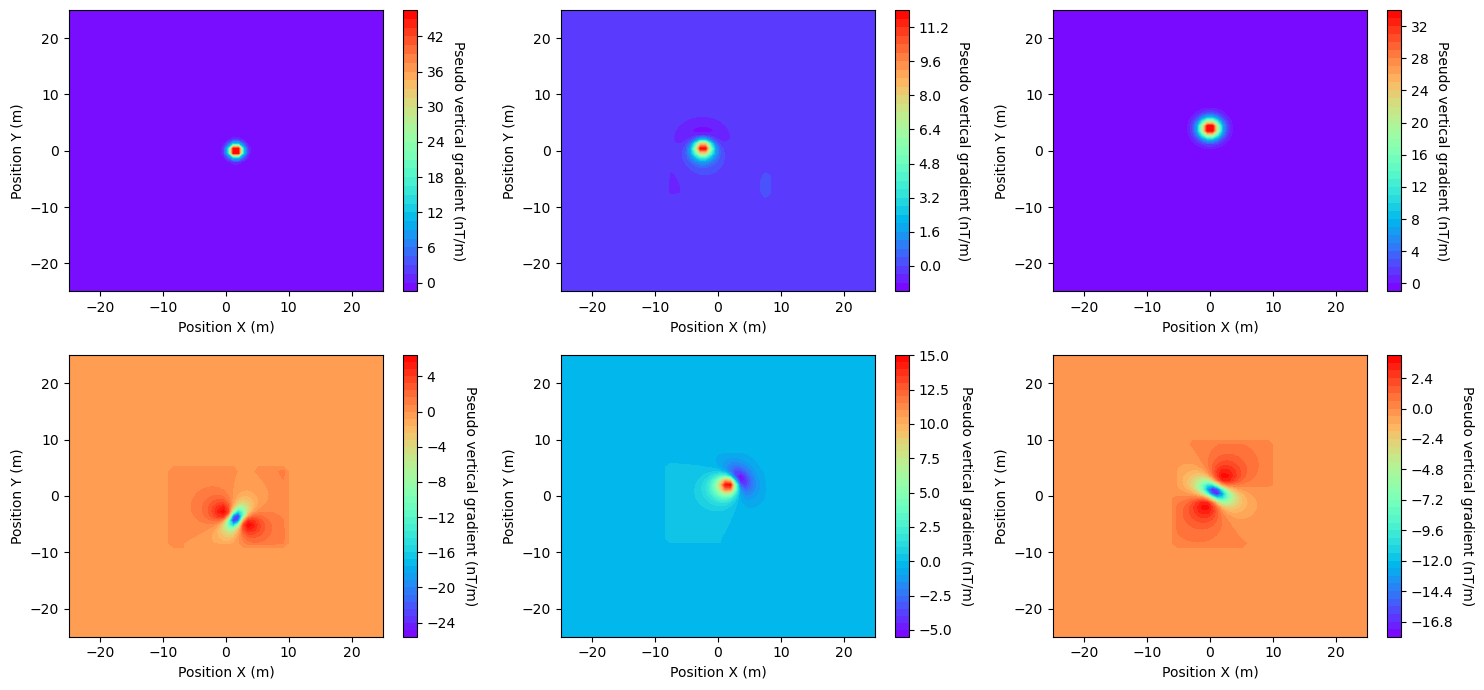

In [19]:
zmax = X_train.shape[1]
map_lenght = 25

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)

# Adjust the size of your images
plt.figure(figsize=(15,7))

# Iterate and plot random images 迭代 绘制随机图像
for i in range(6):

  n_p = int(np.random.randint(0, X_train.shape[0], 1))

  plt.subplot(2, 3, i + 1)
  plt.contourf(X, Y, X_train[n_p,:,:,0], levels = 40, cmap='rainbow')
  plt.axis('on')
  plt.xlabel('Position X (m)')
  plt.ylabel('Position Y (m)')
  clb = plt.colorbar()
  clb.set_label('Pseudo vertical gradient (nT/m)', labelpad=15, y=0.5, rotation=270)
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

In [ ]:
# Parameters : 
# 0 = Declination 赤纬
# 1 = Radius 半径
# 2 = Depth  深a度 

Y_train_par = Y_train[:,1:3]  # 只截取半径和深度
Y_dev_par = Y_dev[:,1:3]
Y_test_par = Y_test[:,1:3]

## Densenet_121
[点击访问官网API指南](https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet121)

[DenseNet：比ResNet更优的CNN模型](https://zhuanlan.zhihu.com/p/37189203)


### ImageNet
[ImageNet维基百科](https://zh.wikipedia.org/zh-cn/ImageNet)

ImageNet项目是一个大型视觉数据库，用于视觉目标识别软件研究。该项目已手动注释了1400多万张图像，以指出图片中的对象，并在至少100万张图像中提供了边框。ImageNet包含2万多个典型类别，例如“气球”或“草莓”，每一类包含数百张图像。尽管实际图像不归ImageNet所有，但可以直接从ImageNet免费获得标注的第三方图像URL。

In [ ]:
Densenet_121 = tf.keras.applications.DenseNet121(
                                                include_top=False,  # 不包括全连接层, 可能主要用于提取特征, 而不分类
                                                weights="imagenet",  # 通过imagNet预训练
                                                input_tensor=None,
                                                input_shape=X_train.shape[1:],
                                                pooling=None,  # 不采用平均池化
                                                classes=1000, 
                                                )

# Densenet_121.summary()

2024-02-29 21:09:46.183873: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-29 21:09:46.186542: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-29 21:09:46.206974: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-02-29 21:09:46.207479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-02-29 21:09:46.207583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2

### Dense Block
Dense Block是 DenseNet 中的一个核心组件。DenseNet（Densely Connected Convolutional Networks）是一种深度学习架构，它的主要创新之一就是引入了密集连接（Dense Connectivity）的概念。

在 DenseNet 中，Dense Block 是由多个密集连接的卷积层组成的模块。每个层都与前面的所有层直接相连，而不仅仅是相邻的层。这种密集连接的结构有助于梯度的传播，避免了梯度消失问题，同时提高了网络的参数利用率。



每个层的输出直接作为后续所有层的输入，形成了密集的连接。这种设计有助于提高网络的表达能力，并且在训练中更容易学习到复杂的特征。 DenseNet 通过多个 Dense Block 的堆叠构建整个网络结构，使得网络更加深层，同时保持较少的参数。

> [深入解析DenseNet(含大量可视化及计算)](https://zhuanlan.zhihu.com/p/141178215)  
注: 学习时间有限,有些看不懂,用于理解Dense Block

#### conv_block函数
这是一个用于构建卷积块（convolutional block）的函数，通常在深度学习中用于构建神经网络的层。以下是对该函数的解释：

1. **参数解释：**
    - `x`: 输入张量。
    - `stage`: dense block 的索引。
    - `branch`: 每个 dense block 内的层索引。
    - `nb_filter`: 每个卷积层的滤波器数量。
    - `dropout_rate`: 可选的 dropout 率，用于防止过拟合。
    - `weight_decay`: 权重衰减因子，用于控制权重的正则化。

2. **内部变量：**
    - `concat_axis`: 通道轴的索引。
    - `eps`: 用于数值稳定性的小常数。
    - `conv_name_base` 和 `relu_name_base`: 用于命名每个卷积层和激活层的基本名称。
    - `inter_channel`: 通过 1x1 卷积层计算的中间通道数，是 `nb_filter` 的四倍。

3. **函数流程：**
    - 1x1 卷积层（瓶颈层）：BatchNormalization -> ReLU -> 1x1 卷积。
    - 如果指定了 `dropout_rate`，则应用 Spatial Dropout。
    - 3x3 卷积层：BatchNormalization -> ReLU -> ZeroPadding -> 3x3 卷积。
    - 如果指定了 `dropout_rate`，则再次应用 Spatial Dropout。

4. **返回值：**
    - 返回卷积块处理后的张量。

这个函数实现了一个常见的卷积块结构，通过堆叠这样的块，可以构建深度神经网络，如 DenseNet 等。

In [ ]:
# Dense Block
def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):

  '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
  concat_axis = -1

  eps = 1.1e-5
  conv_name_base = 'conv' + str(stage) + '_' + str(branch)
  relu_name_base = 'relu' + str(stage) + '_' + str(branch)

  # 1x1 Convolution (Bottleneck layer)
  inter_channel = nb_filter * 4  

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
  x = Activation('relu', name=relu_name_base+'_x1')(x)
  x = Conv2D(inter_channel, (1,1), name=conv_name_base+'_x1', use_bias=False)(x)
  
  
  if dropout_rate:
    x = SpatialDropout2D(dropout_rate)(x)

  # 3x3 Convolution
  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
  x = Activation('relu', name=relu_name_base+'_x2')(x)
  x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
  x = Conv2D(nb_filter, (3, 3), name=conv_name_base+'_x2', use_bias=False)(x)
  
  if dropout_rate:
    x = SpatialDropout2D(dropout_rate)(x)

  return x


#### transition_block函数

这是一个用于构建过渡块（transition block）的函数，通常在深度学习中用于连接两个密集块（dense block）之间的层。以下是对该函数的解释：

1. **参数解释：**
    - `x`: 输入张量。
    - `stage`: 过渡块的索引。
    - `nb_filter`: 过渡块中每个卷积层的滤波器数量。
    - `compression`: 压缩因子，计算为 1 - reduction，用于减少过渡块中的特征图数量。
    - `dropout_rate`: 可选的 dropout 率，用于防止过拟合。
    - `weight_decay`: 权重衰减因子，用于控制权重的正则化。

2. **内部变量：**
    - `eps`: 用于数值稳定性的小常数。
    - `conv_name_base`、`relu_name_base` 和 `pool_name_base`: 用于命名每个卷积层、激活层和池化层的基本名称。
    - `concat_axis`: 通道轴的索引。

3. **函数流程：**
    - BatchNormalization -> ReLU -> 1x1 卷积层。
    - 如果指定了 `dropout_rate`，则应用 Spatial Dropout。
    - 注释掉的平均池化层（AveragePooling2D）：通常用于减小特征图的空间维度，但在这个实现中被注释掉了。

4. **返回值：**
    - 返回过渡块处理后的张量。

该函数通过连接 BatchNormalization、ReLU 激活和 1x1 卷积层构建了一个过渡块，用于在 DenseNet 架构中调整特征图的数量。

In [ ]:

def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
  ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
  eps = 1.1e-5

  conv_name_base = 'conv' + str(stage) + '_blk'
  relu_name_base = 'tanh' + str(stage) + '_blk'
  pool_name_base = 'pool' + str(stage) 

  concat_axis = -1

  x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
  x = Activation('relu', name=relu_name_base)(x)
  x = Conv2D(int(nb_filter * compression), (1,1), name=conv_name_base, use_bias=False)(x)

  if dropout_rate:
      x = SpatialDropout2D(dropout_rate)(x)

  #x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

  return x


#### dense_block函数
这是一个用于构建稠密块（dense block）的函数，通常用于 DenseNet 架构中。以下是对该函数的解释：

1. **参数解释：**
    - `x`: 输入张量。
    - `stage`: 稠密块的索引。
    - `nb_layers`: 在稠密块中添加的 conv_block 层的数量。
    - `nb_filter`: 稠密块中每个 conv_block 层的滤波器数量。
    - `growth_rate`: 增长率，即每个 conv_block 层输出的通道数。
    - `dropout_rate`: 可选的 dropout 率，用于防止过拟合。
    - `weight_decay`: 权重衰减因子，用于控制权重的正则化。
    - `grow_nb_filters`: 一个标志，决定是否允许滤波器数量增加。

2. **内部变量：**
    - `eps`: 用于数值稳定性的小常数。
    - `concat_feat`: 用于存储每个 conv_block 输出的张量，并在每次循环后与新的张量连接。

3. **函数流程：**
    - 使用 `for` 循环迭代 `nb_layers` 次，每次调用 `conv_block` 函数构建一个卷积块。
    - 将当前 conv_block 输出的张量与之前的所有张量连接起来，构建一个更大的特征图。
    - 如果设置了 `grow_nb_filters`，则更新 `nb_filter`，使其增加 `growth_rate`。

4. **返回值：**
    - 返回最终连接的稠密块的输出张量 `concat_feat` 和更新后的 `nb_filter`。

该函数通过堆叠多个卷积块（`conv_block`）并连接它们的输出，构建了一个稠密块。这是 DenseNet 网络中关键的模块，有助于促使信息的高效传递和共享。

In [ ]:

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = Concatenate(axis=-1, name='concat_'+str(stage)+'_'+str(branch))([concat_feat,x])
        #concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


### DenseNet 架构
这是一个用于构建 DenseNet 架构的代码片段，包括了多个稠密块、过渡块和全局平均池化的层。以下是对代码的解释：

1. **DenseNet 参数设置：**
   - `nb_dense_block`: 稠密块的数量。
   - `growth_rate`: 稠密块中每个 conv_block 层的输出通道数。
   - `nb_filter`: 初始的卷积层滤波器数量。
   - `nb_layers`: 一个列表，表示每个稠密块中 conv_block 层的数量。
   - `compression`: 过渡块中的压缩因子，用于减小特征图的数量。
   - `dropout_rate`: dropout 率。
   - `weight_decay`: 权重衰减因子。
   - `l2_regularizer`: L2 正则化的权重。
   
2. **模型构建过程：**
   - 通过迭代 `nb_dense_block` 次，调用 `dense_block` 和 `transition_block` 函数构建 DenseNet 的主体结构。
   - 在每个稠密块后都添加了一个过渡块，通过 `transition_block` 函数调整特征图的数量。
   - 最后，使用全局平均池化层对特征图进行降维。
   - 添加了一个全连接层和激活函数，最终输出大小为 `Y_train_par.shape[1]`。

3. **模型结构设置：**
   - 设置模型的输入为 `Densenet_121` 模型的输入。
   - 设置输出为一个带有线性激活函数的密集层，其大小为 `Y_train_par.shape[1]`。

4. **模型可训练参数设置：**
   - 将模型的前141层（包括 DenseNet 部分）设置为可训练。
   - 从第142层开始的所有层也设置为可训练。

5. **模型总结：**
   - 使用 `model.summary()` 打印模型的摘要信息，包括每一层的参数数量等信息。

这段代码构建了一个 DenseNet 模型，适用于特定的任务，其中包含多个稠密块和过渡块。

In [ ]:
nb_dense_block=0 
growth_rate=32
nb_filter=256
reduction=0.0
dropout_rate=0.0
weight_decay=1e-4

nb_layers = [6,12]

compression = 0.5

l2_regularizer = 0.005

####################

x = Densenet_121.layers[140].output

for block_idx in range(nb_dense_block):

  stage = block_idx+4
  x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

  # Add transition_block
  x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
  nb_filter = int(nb_filter * compression)

#final_stage = stage + 1
#x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

x = GlobalAveragePooling2D(name='Global_Average_Pooling_2D')(x)

x = Dense(256, kernel_initializer='GlorotUniform', kernel_regularizer=l2(l2_regularizer))(x)
x = Activation("relu")(x)

x = Dense(Y_train_par.shape[1], activation= "linear", name='rotation')(x)

model = Model(inputs = Densenet_121.input, outputs = x)

for layer in model.layers[:141]:
#for layer in position_model.layers[:9]:
  layer.trainable=True
for layer in model.layers[141:]:
#for layer in position_model.layers[9:]:
  layer.trainable=True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### 评估指标的函数
这是一个计算R²（R-squared）评估指标的函数，用于评估回归模型的性能。以下是对该函数的解释：

1. **参数解释：**
    - `y_true`: 真实值的张量。
    - `y_pred`: 预测值的张量。

2. **函数流程：**
    - 计算残差平方和（SS_res）：真实值与预测值之差的平方的总和。
    - 计算总平方和（SS_tot）：真实值与真实值均值之差的平方的总和。
    - 使用上述计算结果计算 R² 值epsilon 是一个小的常数，用于避免除零错误。

3. **返回值：**
    - 返回 R² 值，该值越接近1表示模型对数据的拟合越好，越接近0表示模型的拟合效果较差。

这个函数利用了 R² 的定义，通过比较实际值与预测值之间的差异来评估模型的表现。

In [ ]:
def r2(y_true, y_pred):

    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)) )
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()))


### 重新编译模型
这段代码重新编译了模型（`model`），设置了新的优化器、损失函数和评估指标。以下是对代码的解释：

1. **重新编译模型参数解释：**
   - `optimizer`: 优化器，这里使用Adam，学习率为1e-5。
   - `loss`: 损失函数，这里使用均方误差（MSE）。
   - `metrics`: 评估指标，这里使用了自定义的R²函数。

2. **重新编译模型：**
   - 通过 `compile` 函数重新编译模型，配置了新的优化器、损失函数和评估指标。
   - 这可能是为了确保在重新使用模型进行训练时，使用了正确的配置。

这段代码使得`model`可以用于进一步的训练或其他任务，并确保了正确的模型配置。

In [ ]:
model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss= MSE,
              metrics= [r2])

## 验证与评估

导入模型并重新编译模型

In [ ]:
load_path = "./content/Densenet_par_9_TL copy.hdf5"

best_model = load_model(load_path, custom_objects={'r2': r2})
best_model.summary()
best_model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss= MSE,
              metrics= [r2])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

评估测试集

In [ ]:

####### Evaluating test set ##########
train_loss= best_model.evaluate(X_train, Y_train_par, verbose=0)

dev_loss= best_model.evaluate(X_dev, Y_dev_par, verbose=0)
test_loss= best_model.evaluate(X_test, Y_test_par, verbose=0)


2024-02-29 21:10:38.475104: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-29 21:10:38.475609: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2500050000 Hz
2024-02-29 21:10:39.714121: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-02-29 21:10:40.483365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


In [ ]:

#print(f"Train loss = {np.round(train_loss,decimals=5)}, Train accuracy = {np.round(train_acc, decimals=3)}")
#print(f"Dev loss = {np.round(dev_loss, decimals=5)}, Dev accuracy = {np.round(dev_acc, decimals=3)}")
#print(f"Test loss = {np.round(test_loss, decimals=5)}, Test accuracy = {np.round(test_acc, decimals=3)}")

print(f"Train loss = {np.round(train_loss,decimals=5)}")
print(f"Dev loss = {np.round(dev_loss, decimals=5)}")
print(f"Test loss = {np.round(test_loss, decimals=5)}")


Train loss = [0.00481 0.99993]
Dev loss = [0.00486 0.99979]
Test loss = [0.00486 0.9998 ]


预测

In [ ]:
####### Predicting test set ##########

Parameters_predictions_norm = best_model.predict(X_test, verbose=0)

Y_test_par[:,0] = np.round(Y_test_par[:,0], decimals = 1)
Y_test_par[:,1] = np.round(Y_test_par[:,1], decimals = 1)
#Y_test_par[:,2] = np.round(Y_test_par[:,1], decimals = 1)

Parameters_predictions_norm[:,0] = np.round(Parameters_predictions_norm[:,0], decimals = 1)
Parameters_predictions_norm[:,1] = np.round(Parameters_predictions_norm[:,1], decimals = 1)
#Parameters_predictions_norm[:,2] = np.round(Parameters_predictions_norm[:,2], decimals = 1)


[0.1 1.2]
[0.1 1.2]


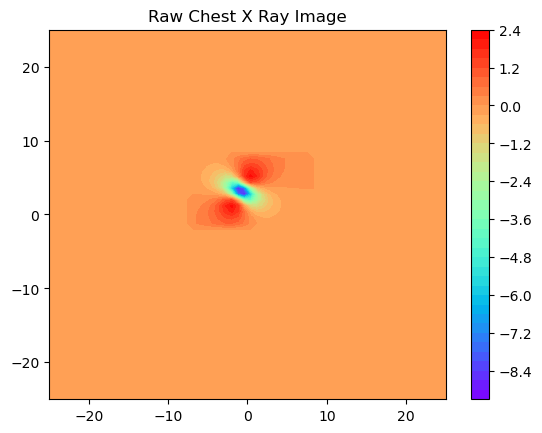

In [ ]:
nn = np.random.randint(X_test.shape[0])

zmax= 32

conversion = (25*2)/zmax

sample_img = X_test[nn,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(Y_test_par[nn])
print(Parameters_predictions_norm[nn])


In [ ]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_real = Y_test_par[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_real = Y_test_par[:,1]

In [ ]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_predicted = Parameters_predictions_norm[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_predicted = Parameters_predictions_norm[:,1]

可视化

/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<Axes: >

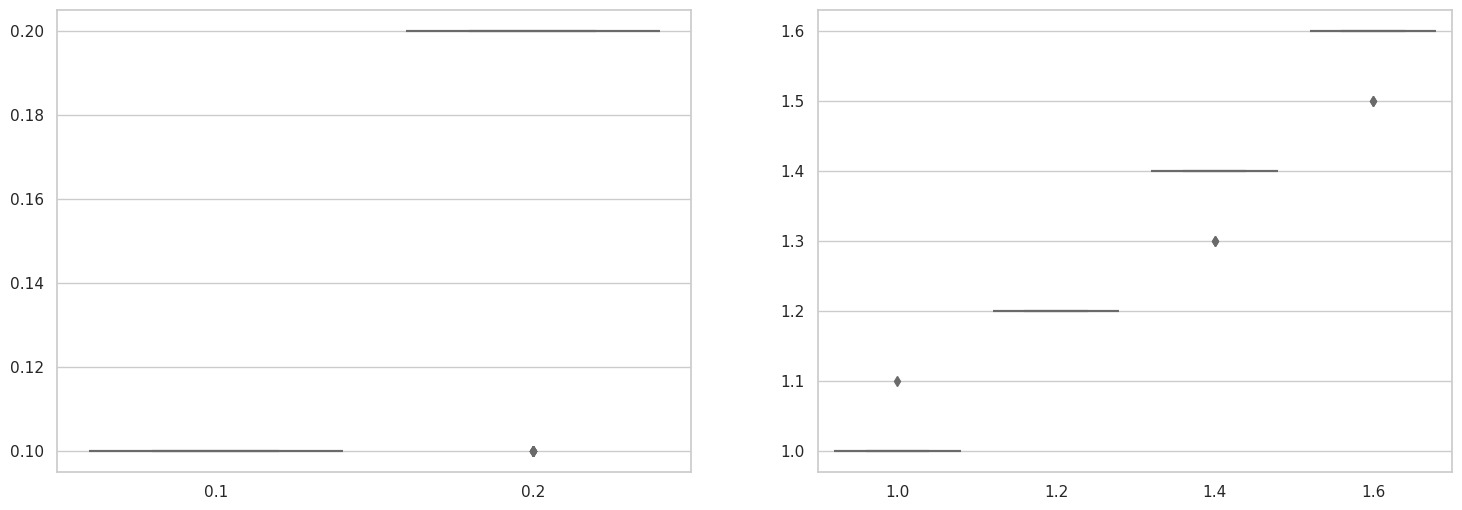

In [ ]:
# Box plot visualization 

fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.set(style="whitegrid")

sns.boxplot(x=r_real[:], y=r_predicted[:], palette="Set3", ax=ax[0])

sns.boxplot(x=Depth_real[:], y=Depth_predicted[:], palette="Set3", ax=ax[1])


Box plot（箱线图）是一种用于可视化数据分布和离群值的统计图表。它提供了一组关于数据集中心趋势、离散程度和异常值的信息。以下是箱线图的主要元素和其解释：

1. **箱体（Box）：**
   - 表示数据分布的中间50%（第一四分位数到第三四分位数之间）。
   - 箱体的上边界是第三四分位数（Q3），下边界是第一四分位数（Q1）。
   - 箱体的长度（高度）表示数据的离散程度，越长表示数据的变异性越大。

2. **中位数线（Median Line）：**
   - 在箱体中间绘制一条线，表示数据的中位数（第二四分位数，Q2）。
   - 中位数是数据的中心趋势指标，是将数据按大小排序后的中间值。

3. **须线（Whiskers）：**
   - 两条延伸自箱体的线，表示数据集的最小和最大值。
   - 须线通常由内限和外限组成，内限通常为1.5倍的四分位距（Q3-Q1），外限为内限的1.5倍。
   - 超过外限的数据点被认为是异常值。

4. **离群值（Outliers）：**
   - 在须线之外的数据点，可能是数据分布中的异常值。
   - 在箱线图中通常以点或其他标记形式显示。

通过箱线图，可以直观地看出数据的中心趋势、分布形状以及是否存在离群值。这使得箱线图成为数据探索和比较的有效工具。